# 11-13. 프로젝트: 뉴스기사 요약해보기

### [루브릭]
1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.
    - 분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.


2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.
    - 모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, 실제 요약문과 유사한 요약문장을 얻을 수 있었다.
    
    
3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.
    - 두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시하였다.

### [학습과정]
1. 데이터 수집하기
2. 데이터 전처리하기(추상적 요약)
3. 어텐션 메커니즘 사용하기 (추상적 요약)
4. 실제 결과와 요약문 비교하기 (추상적 요약)
5. Summa을 이용해서 추출적 요약해보기

### [결과 및 회고]

## 1. 데이터 수집하기

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

[nltk_data] Downloading package stopwords to /home/ssac18/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import pandas as pd
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
53240,Death toll in Nepal cold wave rises to 24,The death toll resulting from the intense cold...
66760,Toddler rescued after 12 hours in Swiss Alps c...,Over 100 rescue workers helped pull a two-year...
35933,Decomposed body of 50-year-old found at her ho...,The Mumbai police on Wednesday recovered the d...
29126,Girl kills self after mall staff harass her fo...,A girl in Tripura committed suicide after she ...
34969,"Cutie pie, sorry bhai: Pandya to Kishan after ...",All-rounder Hardik Pandya took to social media...
58212,"4,093 Maha schools with less than 10 students ...",The Maharashtra government has decided to shut...
36145,"Delhi airport to get bigger T1 and T3, new run...",DelhiÃ¢ÂÂs Indira Gandhi International Airpo...
28377,Sari-clad man thrashed on suspicion of being c...,A sari-clad man was thrashed on the suspicion ...
51401,"I am not on Twitter, read printouts of Trump t...",US State Secretary Rex Tillerson has revealed ...
94094,US deploys naval strike group near North Korea,US has deployed a navy strike group towards th...


In [4]:
len(data)

98401

우리는 text 시퀀스를 입력받으면 headlines를 예측하도록 신경망을 훈련시키려고 합니다.

## 2. 데이터 전처리하기

우선, 유니크한 데이터가 몇개있는지 확인해봅니다.

In [5]:
print('headlines의 유니크한 데이터 수 : ', data['headlines'].nunique())
print('text의 유니크한 데이터 수 : ', data['text'].nunique())

headlines의 유니크한 데이터 수 :  98280
text의 유니크한 데이터 수 :  98360


headline의 유니크한 데이터가 text보다 약 100여개 더 많습니다. text가 달라도 헤드라인이 같은 경우가 있으나 text가 중복된 경우는 본문 자체가 동일하다는 뜻이므로 중복 샘플을 제거해줍니다.

In [6]:
data.drop_duplicates(subset = ['text'], inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98360


In [7]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


텍스트 정규화와 불용어 제거

In [8]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


In [9]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [10]:
# 데이터 전처리 함수

def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower()    # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text   # <> 등 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (~~) 제거
    sentence = re.sub('""', '', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])  # 약어 정규화
    sentence = re.sub(r"'s\b", "", sentence)  # 소유격 제거. Her's => Her
    sentence = re.sub("[^a-zA-Z]", " ", sentence)   # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence)   # m이 3개 이상이면 2개로 변경 ummmm 이런거
    
    # 불용어 제거 (in text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    
    # 불용어 미제거 (in headlines) 제거하면 오히려 어색함
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
    

In [11]:
# 전처리 전후 결과 확인하기 위한 임의의 데이터 호출

temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headline = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_headline, False))  # 불용어를 제거하지 않습니다.

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


In [12]:
clean_text = []

# 전체 Text 데이터에 대한 전처리 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [13]:
clean_headline = []

# 전체 Summary 데이터에 대한 전처리 
for s in data['headlines']:
    clean_headline.append(preprocess_sentence(s, False))

clean_headline[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

In [14]:
data['text'] = clean_text
data['headlines'] = clean_headline

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [15]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

샘플의 최대 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.097763318422125
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.29956283041887


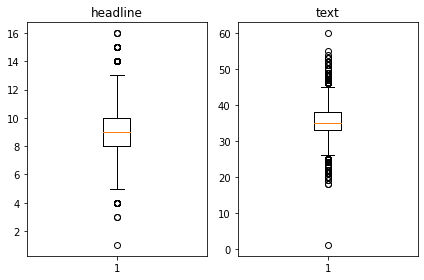

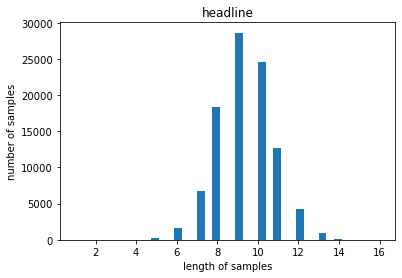

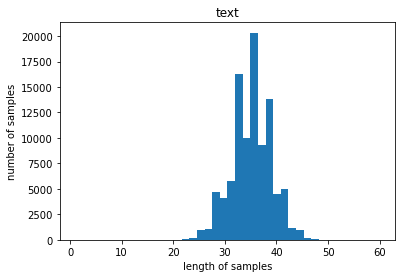

In [16]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headline_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headline_len)))
print('요약의 최대 길이 : {}'.format(np.max(headline_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headline_len)))

plt.subplot(1,2,1)
plt.boxplot(headline_len)
plt.title('headline')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headline')
plt.hist(headline_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [18]:
text_max_len = 38
headline_max_len = 11

In [19]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if (len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
    

In [20]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headline_max_len,  data['headlines'])

전체 샘플 중 길이가 38 이하인 샘플의 비율: 0.8164497763318422
전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.9449877999186661


In [21]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headline_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 75765


시작 토큰과 종료 토큰 추가하기

In [22]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가.

data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
7,govt directs alok verma to join work day befor...,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...
8,called pm modi sir times to satisfy his ego an...,andhra pradesh cm chandrababu naidu said met u...,sostoken called pm modi sir times to satisfy h...,called pm modi sir times to satisfy his ego an...


In [23]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장

encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [24]:
# 훈련 데이터 테스트 데이터 분리

indices = np.arange(encoder_input.shape[0])  # encoder_input과 크기와 형태가 같은 정수 시퀀스 생성
np.random.shuffle(indices)                   # 순서를 랜덤하게 섞어줍니다
print(indices) # 랜덤한 정수 시퀀스 생성!

[74969  4166 16875 ... 64989 30761 43270]


In [25]:
# 샘플 순서를 랜덤 시퀀스를 이용해서 정의해줌

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [26]:
# 8:2로 훈련셋 테스트셋 분리

n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 15153


In [27]:
# 테스트 데이터의 갯수를 이용해 전체 데이터를 양분해줌

encoder_input_train = encoder_input[:-n_of_val] # 뒤로 n_of_val개 빼고 나머지
decoder_input_train = decoder_input[:-n_of_val] 
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:] # 앞에 n_of_val개 빼고 나머지
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 : ', len(encoder_input_train))
print('훈련 레이블의 개수 : ', len(decoder_input_train))
print('테스트 데이터의 개수 : ', len(encoder_input_test))
print('테스트 데이터의 개수 : ', len(decoder_input_test))

훈련 데이터의 개수 :  60612
훈련 레이블의 개수 :  60612
테스트 데이터의 개수 :  15153
테스트 데이터의 개수 :  15153


단어 집합 만들기 & 정수 인코딩

In [28]:
src_tokenizer = Tokenizer()    # 토크나이저 생성 - 입력된 훈련 데이터로부터 단어집합 생성 가능하게 해줌
src_tokenizer.fit_on_texts(encoder_input_train)       # 입력된 데이터로부터 단어 집합 생성

In [ ]:
# 단어집합이 생성되었고, 각 단어에 고유한 정수가 부여됨. 
# 빈도수 낮은 단어들은 훈련데이터에서 제거

In [29]:
threshold = 8
total_count = len(src_tokenizer.word_index)      # 단어의 수
rare_count = 0             # 등장 빈도수가 threshold보다 작은 단어의 개수를 count
total_freq = 0             # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0              # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받음.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value
    
    # 단어의 등장 빈도수가 threshold보다 작으면
    if (value < threshold) :
        rare_count = rare_count + 1
        rare_freq = rare_freq + value
        
print('단어 집합의 크기 : ', total_count)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_count))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: %s'%(total_count - rare_count))
print("단어 집합에서 희귀 단어의 비율:", (rare_count / total_count)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합의 크기 :  60383
등장 빈도가 7번 이하인 희귀 단어의 수: 42621
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: 17762
단어 집합에서 희귀 단어의 비율: 70.58443601675968
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.540108519025879


In [31]:
src_vocab = 17500
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 17,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [32]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[31, 28, 4578, 1246, 10486, 1711, 76, 130, 52, 8391, 30, 1004, 62, 2140, 647, 12, 1179, 620, 1403, 1403, 2710, 16657, 647, 1432, 1955, 5, 30, 6132, 1238, 117, 6932, 1356], [78, 143, 74, 7060, 5557, 696, 505, 352, 480, 1, 9, 1066, 2911, 9007, 1712, 3166, 327, 2911, 10487, 1432, 394, 9008, 93, 2911, 5165, 893, 567, 9, 2, 1, 4, 1936, 257, 186, 1438, 440, 1936], [70, 7196, 827, 9647, 1, 3527, 992, 2931, 5416, 11, 633, 117, 131, 362, 177, 7196, 2, 1379, 3495, 2116, 623, 2129, 1, 608, 1059, 1850, 131, 8045]]


In [33]:
# headlines 에도 동일한 작업해주기
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [37]:
threshold = 7
total_count = len(tar_tokenizer.word_index)      # 단어의 수
rare_count = 0             # 등장 빈도수가 threshold보다 작은 단어의 개수를 count
total_freq = 0             # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0              # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받음.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value
    
    # 단어의 등장 빈도수가 threshold보다 작으면
    if (value < threshold) :
        rare_count = rare_count + 1
        rare_freq = rare_freq + value
        
print('단어 집합의 크기 : ', total_count)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_count))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: %s'%(total_count - rare_count))
print("단어 집합에서 희귀 단어의 비율:", (rare_count / total_count)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합의 크기 :  27069
등장 빈도가 6번 이하인 희귀 단어의 수: 18846
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: 8223
단어 집합에서 희귀 단어의 비율: 69.6220769145517
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.415769208216876


In [38]:
tar_vocab = 8000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

In [39]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 2567, 168, 6521, 3376, 6522, 19, 5, 3377, 396], [1, 330, 215, 75, 2285, 2226, 7, 7554, 26, 48], [1, 185, 11, 71, 246, 5, 229, 4540, 7, 2057, 3618, 1770], [1, 185, 11, 908, 51, 5, 159, 19, 43, 4196, 7025], [1, 1671, 5, 7555, 4, 1044, 3514, 34]]
target
decoder  [[2567, 168, 6521, 3376, 6522, 19, 5, 3377, 396, 2], [330, 215, 75, 2285, 2226, 7, 7554, 26, 48, 2], [185, 11, 71, 246, 5, 229, 4540, 7, 2057, 3618, 1770, 2], [185, 11, 908, 51, 5, 159, 19, 43, 4196, 7025, 2], [1671, 5, 7555, 4, 1044, 3514, 34, 2]]


In [40]:
# headline의 길이가 1인 경우(실제로는 길이가 0)의 인덱스를 저장해보자
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 60612
훈련 레이블의 개수 : 60612
테스트 데이터의 개수 : 15153
테스트 레이블의 개수 : 15153


/home/ssac18/anaconda3/envs/aiffel/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [42]:
# post padding. 뒤의 공간에 숫자 0을 넣어준다
# 아까 지정해주었던 최대 길이로 패딩.
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = headline_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = headline_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = headline_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = headline_max_len, padding='post')

## 3. Attention 메커니즘 사용하기

In [43]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout = 0.4 )
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [44]:
# 디코더 설계

decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [45]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 128)      2240000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 38, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [46]:
# 어텐션 함수 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [47]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 128)      2240000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 38, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [48]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
237/237 [==============================] - 67s 284ms/step - loss: 5.8782 - val_loss: 5.4443
Epoch 2/50
237/237 [==============================] - 67s 282ms/step - loss: 5.3298 - val_loss: 5.1138
Epoch 3/50
237/237 [==============================] - 67s 284ms/step - loss: 5.0014 - val_loss: 4.8227
Epoch 4/50
237/237 [==============================] - 67s 284ms/step - loss: 4.7245 - val_loss: 4.6276
Epoch 5/50
237/237 [==============================] - 67s 283ms/step - loss: 4.5095 - val_loss: 4.4875
Epoch 6/50
237/237 [==============================] - 67s 283ms/step - loss: 4.3344 - val_loss: 4.3781
Epoch 7/50
237/237 [==============================] - 67s 283ms/step - loss: 4.1802 - val_loss: 4.2825
Epoch 8/50
237/237 [==============================] - 67s 282ms/step - loss: 4.0433 - val_loss: 4.1980
Epoch 9/50
237/237 [==============================] - 67s 282ms/step - loss: 3.9190 - val_loss: 4.1453
Epoch 10/50
237/237 [==============================] - 67s 284ms/step - l

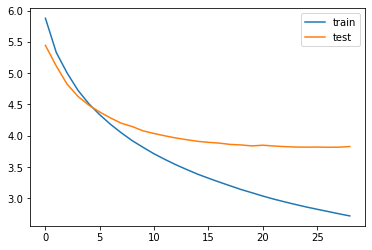

In [49]:
# train, test loss 
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [50]:
# 정수 인덱스로 되어있던 텍스트 데이터를 실제 데이터로 복원하기

src_index_to_word = src_tokenizer.index_word    # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index    # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word    # 요약 던어 집합에서 정수 -> 단어를 얻음

In [51]:
# 인퍼런스 단계에서는 인코더 모델과 디코더 모델 분리해서 설계

# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해 초기 상태를 이전 시점 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련과정과 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h, state_c 를 버리지 않음
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])


In [52]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [53]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headline_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## 4. 실제 결과와 요약문 비교하기 (추상적 요약)

In [54]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [55]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : centre reportedly released crore several projects andhra pradesh amid ongoing political row funds state alleging centre failed allocate funds promised separation andhra pradesh telangana telugu desam party earlier threatened exit nda alliance 
실제 요약 : centre releases crore for andhra projects amid row 
예측 요약 :  govt sanctions crore for crore in andhra pradesh


원문 : fear without mobile phone known short mobile phone people suffer often feel run battery balance lose phone network coverage term reportedly first identified 
실제 요약 : fear of being without mobile phone is called 
예측 요약 :  device to launch phone in smartphones


원문 : female superintendent police tamil nadu filed complaint claiming inspector general rank officer sexually harassing last seven months claimed watched porn front tried hugging kept calling odd hours despite repeated objections also said requests transfer rejected 
실제 요약 : tamil nadu woman sp accuses level officer of sexual harassment 
예측 요약 :  tn police booked

예측 요약 :  player wins us open tennis for wearing


원문 : odisha police thursday busted fake currency printing unit slum bhubaneswar per reports police got know printing unit arrested college student trying use fake note shop police seized papers used printing fake currency notes colour printer spot 
실제 요약 : fake currency printing unit busted at slum in 
예측 요약 :  police arrested for selling people in patanjali


원문 : woman arrested allegedly bit least three flight attendants flight brazil new york forty year old eventually strapped onto seat help flight attendants passengers appeared court wednesday released bond 
실제 요약 : drunk woman who bit flight arrested 
예측 요약 :  woman arrested for drunk plane with plane


원문 : two firs filed west bengal cm mamata banerjee assam alleged instigating remarks said scared lodge millions firs care added done great thing sitting west bengal firs assam 
실제 요약 : two more against mamata banerjee she says not scared 
예측 요약 :  will not allow to get off adityanat

예측 요약 :  prez kovind to be celebrated as prez kovind


원문 : debate fugitive economic offenders bill lok sabha thursday interim finance minister piyush goyal said fails understand foreign accent congress mp shashi tharoor tweet tharoor replied interesting see piyush goyal says cannot understand words explains party keeps 
실제 요약 : do not understand tharoor foreign accent piyush goyal 
예측 요약 :  why is the word of india cji on confidence motion




In [158]:
print("원문 :", seq2text(encoder_input_test[100]))
print("실제 요약 :", seq2summary(decoder_input_test[100]))
print("예측 요약 :", decode_sequence(encoder_input_test[100].reshape(1, text_max_len)))

원문 : sbi chairman rajnish kumar said apart banks borrowers government judiciary role play bad loan problem added power sector stress hope turnaround kumar explained banks mindset investigative agencies lend money based trust 
실제 요약 : govt courts also blame bad loan crisis sbi chairman 
예측 요약 :  sbi sbi deal sbi


## 요약 데이터에 대해서도 불용어를 제거해볼까?

In [56]:
import pandas as pd
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [57]:
data.drop_duplicates(subset = ['text'], inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98360


In [58]:
clean_text = []

# 전체 Text 데이터에 대한 전처리 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [59]:
clean_headline = []

# 전체 Summary 데이터에 대한 전처리 
for s in data['headlines']:
    clean_headline.append(preprocess_sentence(s))

clean_headline[:5]

['upgrad learner switches career ml al salary hike',
 'delhi techie wins free food swiggy one year cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'known hirani yrs metoo claims true sonam']

In [60]:
data['text'] = clean_text
data['headlines'] = clean_headline

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.097763318422125
요약의 최소 길이 : 1
요약의 최대 길이 : 13
요약의 평균 길이 : 7.136213908092721


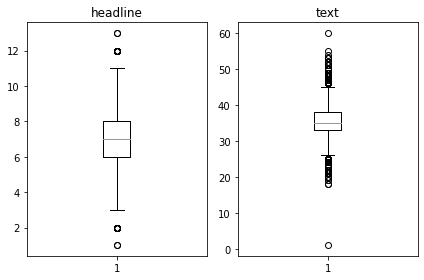

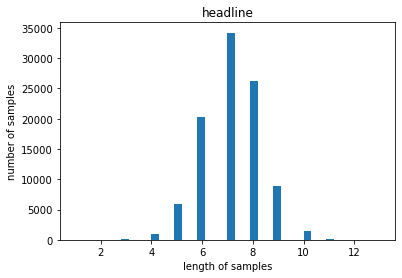

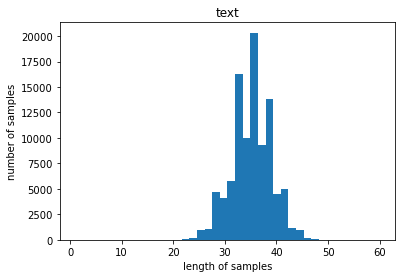

In [61]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headline_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headline_len)))
print('요약의 최대 길이 : {}'.format(np.max(headline_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headline_len)))

plt.subplot(1,2,1)
plt.boxplot(headline_len)
plt.title('headline')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headline')
plt.hist(headline_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [64]:
text_max_len = 38
headline_max_len = 9

In [65]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headline_max_len,  data['headlines'])

전체 샘플 중 길이가 38 이하인 샘플의 비율: 0.8164497763318422
전체 샘플 중 길이가 9 이하인 샘플의 비율: 0.9826250508336722


In [66]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headline_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 79255


In [67]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가.

data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,known hirani yrs metoo claims true sonam,speaking sexual harassment allegations rajkuma...,sostoken known hirani yrs metoo claims true sonam,known hirani yrs metoo claims true sonam eostoken
5,rahat fateh ali khan denies getting notice smu...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice smu...
6,india get lowest odi total new zealand,india recorded lowest odi total new zealand ge...,sostoken india get lowest odi total new zealand,india get lowest odi total new zealand eostoken
7,govt directs alok verma join work day retirement,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma join work day...,govt directs alok verma join work day retireme...


In [68]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장

encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [69]:
# 훈련 데이터 테스트 데이터 분리

indices = np.arange(encoder_input.shape[0])  # encoder_input과 크기와 형태가 같은 정수 시퀀스 생성
np.random.shuffle(indices)                   # 순서를 랜덤하게 섞어줍니다
print(indices) # 랜덤한 정수 시퀀스 생성!

[ 2071 45949   537 ... 72954 39018 35166]


In [70]:
# 샘플 순서를 랜덤 시퀀스를 이용해서 정의해줌

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [71]:
# 8:2로 훈련셋 테스트셋 분리

n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 15851


In [72]:
# 테스트 데이터의 갯수를 이용해 전체 데이터를 양분해줌

encoder_input_train = encoder_input[:-n_of_val] # 뒤로 n_of_val개 빼고 나머지
decoder_input_train = decoder_input[:-n_of_val] 
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:] # 앞에 n_of_val개 빼고 나머지
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 : ', len(encoder_input_train))
print('훈련 레이블의 개수 : ', len(decoder_input_train))
print('테스트 데이터의 개수 : ', len(encoder_input_test))
print('테스트 데이터의 개수 : ', len(decoder_input_test))

훈련 데이터의 개수 :  63404
훈련 레이블의 개수 :  63404
테스트 데이터의 개수 :  15851
테스트 데이터의 개수 :  15851


In [73]:
src_tokenizer = Tokenizer()    # 토크나이저 생성 - 입력된 훈련 데이터로부터 단어집합 생성 가능하게 해줌
src_tokenizer.fit_on_texts(encoder_input_train)       # 입력된 데이터로부터 단어 집합 생성

In [74]:
threshold = 8
total_count = len(src_tokenizer.word_index)      # 단어의 수
rare_count = 0             # 등장 빈도수가 threshold보다 작은 단어의 개수를 count
total_freq = 0             # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0              # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받음.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value
    
    # 단어의 등장 빈도수가 threshold보다 작으면
    if (value < threshold) :
        rare_count = rare_count + 1
        rare_freq = rare_freq + value
        
print('단어 집합의 크기 : ', total_count)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_count))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: %s'%(total_count - rare_count))
print("단어 집합에서 희귀 단어의 비율:", (rare_count / total_count)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합의 크기 :  60944
등장 빈도가 7번 이하인 희귀 단어의 수: 42901
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: 18043
단어 집합에서 희귀 단어의 비율: 70.39413231819374
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.395088787531026


In [75]:
src_vocab = 18000
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [76]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[20, 220, 112, 6374, 1, 1253, 2063, 4272, 963, 2510, 2006, 6030, 738, 972, 2774, 5002, 2063, 2510, 2238, 2774, 5002, 805, 497, 738, 2881, 5002, 1909, 2538, 639], [1079, 371, 306, 633, 2949, 24, 1155, 313, 235, 3893, 14498, 1562, 33, 2949, 24, 14499, 313, 915, 476, 264, 131, 263, 236, 242, 1620, 7608, 1567, 754, 103, 16999, 973, 771, 6871], [181, 651, 114, 10469, 7467, 9899, 1, 45, 16030, 46, 114, 10167, 2355, 98, 3919, 1529, 239, 181, 651, 6757, 117, 5431, 1277, 7467, 9899, 2, 7909, 2356, 16031, 2167, 2]]


In [77]:
# headlines 에도 동일한 작업해주기
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [78]:
threshold = 8
total_count = len(tar_tokenizer.word_index)      # 단어의 수
rare_count = 0             # 등장 빈도수가 threshold보다 작은 단어의 개수를 count
total_freq = 0             # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0              # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받음.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value
    
    # 단어의 등장 빈도수가 threshold보다 작으면
    if (value < threshold) :
        rare_count = rare_count + 1
        rare_freq = rare_freq + value
        
print('단어 집합의 크기 : ', total_count)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_count))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: %s'%(total_count - rare_count))
print("단어 집합에서 희귀 단어의 비율:", (rare_count / total_count)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합의 크기 :  27078
등장 빈도가 7번 이하인 희귀 단어의 수: 19473
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: 7605
단어 집합에서 희귀 단어의 비율: 71.91446931087968
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 8.687743611953227


In [79]:
tar_vocab = 7500
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

In [80]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 82, 5476, 1615, 2667, 3259, 2243], [1, 2161, 838, 415, 197, 106, 338], [1, 5477, 115, 1714, 1053, 223], [1, 557, 54, 953, 98, 88, 2818, 5174, 356], [1, 200, 546, 289, 4535, 54, 877, 563, 53]]
target
decoder  [[82, 5476, 1615, 2667, 3259, 2243, 2], [2161, 838, 415, 197, 106, 338, 2], [5477, 115, 1714, 1053, 223, 2], [557, 54, 953, 98, 88, 2818, 5174, 356, 2], [200, 546, 289, 4535, 54, 877, 563, 53, 2]]


In [81]:
# headline의 길이가 1인 경우(실제로는 길이가 0)의 인덱스를 저장해보자
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 4
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 63400
훈련 레이블의 개수 : 63400
테스트 데이터의 개수 : 15851
테스트 레이블의 개수 : 15851


/home/ssac18/anaconda3/envs/aiffel/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [82]:
# post padding. 뒤의 공간에 숫자 0을 넣어준다
# 아까 지정해주었던 최대 길이로 패딩.
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = headline_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = headline_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = headline_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = headline_max_len, padding='post')

In [84]:
# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout = 0.4 )
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output3, state_h, state_c= encoder_lstm3(encoder_output2)

# 인코더의 LSTM 4
encoder_lstm4 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm4(encoder_output3)

In [85]:
# 디코더 설계

decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [86]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 38, 128)      2304000     input_7[0][0]                    
__________________________________________________________________________________________________
lstm_8 (LSTM)                   [(None, 38, 256), (N 394240      embedding_3[0][0]                
__________________________________________________________________________________________________
lstm_9 (LSTM)                   [(None, 38, 256), (N 525312      lstm_8[0][0]                     
____________________________________________________________________________________________

In [87]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 38, 128)      2304000     input_7[0][0]                    
__________________________________________________________________________________________________
lstm_8 (LSTM)                   [(None, 38, 256), (N 394240      embedding_3[0][0]                
__________________________________________________________________________________________________
lstm_9 (LSTM)                   [(None, 38, 256), (N 525312      lstm_8[0][0]                     
____________________________________________________________________________________________

In [88]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
248/248 [==============================] - 80s 321ms/step - loss: 5.8476 - val_loss: 5.4772
Epoch 2/50
248/248 [==============================] - 81s 325ms/step - loss: 5.3492 - val_loss: 5.1126
Epoch 3/50
248/248 [==============================] - 81s 326ms/step - loss: 5.0233 - val_loss: 4.8779
Epoch 4/50
248/248 [==============================] - 81s 326ms/step - loss: 4.7713 - val_loss: 4.6905
Epoch 5/50
248/248 [==============================] - 81s 327ms/step - loss: 4.5555 - val_loss: 4.5450
Epoch 6/50
248/248 [==============================] - 81s 326ms/step - loss: 4.3698 - val_loss: 4.4340
Epoch 7/50
248/248 [==============================] - 81s 328ms/step - loss: 4.2091 - val_loss: 4.3319
Epoch 8/50
248/248 [==============================] - 82s 329ms/step - loss: 4.0706 - val_loss: 4.2685
Epoch 9/50
248/248 [==============================] - 82s 330ms/step - loss: 3.9428 - val_loss: 4.2211
Epoch 10/50
248/248 [==============================] - 82s 330ms/step - l

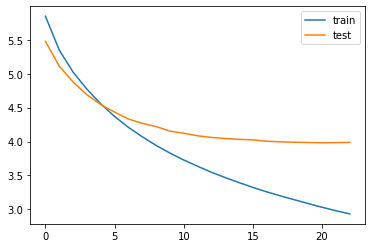

In [89]:
# train, test loss 
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [90]:
# 정수 인덱스로 되어있던 텍스트 데이터를 실제 데이터로 복원하기

src_index_to_word = src_tokenizer.index_word    # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index    # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word    # 요약 던어 집합에서 정수 -> 단어를 얻음

In [91]:
# 인퍼런스 단계에서는 인코더 모델과 디코더 모델 분리해서 설계

# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해 초기 상태를 이전 시점 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련과정과 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h, state_c 를 버리지 않음
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])


In [92]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [94]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 헤드라인 :", seq2summary(decoder_input_test[i]))
    print("예측 헤드라인 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : study financial services company ubs revealed person working mumbai work days afford iphone delhi person work days cairo person work days person zurich afford iphone days 
실제 헤드라인 : many days one work around world buy iphone 
예측 헤드라인 :  indian cola revenue


원문 : reacting french footballer antoine griezmann new haircut user tweeted griezmann shocks world sporting possibly worst haircut history users reacted tweets like antoine griezmann new haircut words griezmann looking like refusing shower completes move united solidarity 
실제 헤드라인 : history worst possible tweets user 
예측 헤드라인 :  twitter reacts opponent


원문 : mexican drug lord el guzman claimed extradition us mexico violated terms us mexico treaty according terms guzman transferred either california texas however day extradition mexico waived terms instead send new york guzman lawyers said 
실제 헤드라인 : mexican drug lord questions us extradition 
예측 헤드라인 :  us senator accuses us embassy jerusalem


원문 : mumbai railway lines chroni

예측 헤드라인 :  russian journalist accidentally lets users steal photos


원문 : asserting cannabis indigenous india form congress mp shashi tharoor said india legalise regulate production supply use cannabis stating alcohol tobacco far harmful cannabis tharoor claimed regulation would allow consumers know strength drug 
실제 헤드라인 : shashi tharoor calls cannabis india 
예측 헤드라인 :  tharoor promises ban use plastic ads


원문 : alumni association indian institute science bengaluru cancelled workshop scheduled next month facing opposition faculty members researchers alumni pointing belief system scientific basis protesters said workshop would grave damage reputation integrity institution 
실제 헤드라인 : iisc bengaluru cancelled protest 
예측 헤드라인 :  railways launches new


원문 : huma qureshi speaking red carpet appearances cannes film festival said bollywood got right many years looked beautiful yet different one another think anyone went top time added huma said always excited know wearing red carpet 
실제 헤드

In [ ]:
print("원문 :", seq2text(encoder_input_test[100]))
print("실제 요약 :", seq2summary(decoder_input_test[100]))
print("예측 요약 :", decode_sequence(encoder_input_test[100].reshape(1, text_max_len)))

## 5. Summa을 이용해서 추출적 요약해보기

In [136]:
import requests
from summa.summarizer import summarize

In [137]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [138]:
text = data['text']
text[0]

"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers."

In [166]:
print('Summary:')
print(summarize(text[0], words=5))

Summary:
upGrad's Online Power Learning has powered 3 lakh+ careers.


In [154]:
# 리스트로 출력결과 받기
print('Summary:')
print(summarize(text[0], ratio=0.4, split=True))

Summary:
["upGrad's Online Power Learning has powered 3 lakh+ careers."]


In [173]:
headlines = []
for i in range(len(text)):
    headline = summarize(text[i], ratio=0.4)
    headlines.append(headline)

In [174]:
headlines[:5]

["upGrad's Online Power Learning has powered 3 lakh+ careers.",
 'Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.',
 'The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.',
 'Also, customers have options to insure against Critical Illnesses, Disability and Accidental Death Benefit Rider with a life cover up to the age of 80 years.',
 'Speaking about the sexual harassment allegations against Rajkumar Hirani, Sonam Kapoor said, "I\'ve known Hirani for many years...What if it\'s not true, the [#MeToo] movement will get derailed." "In the #MeToo movement, I always believe a woman.']

In [176]:
for i in range(10):
    print("원문 :", data['text'][i])
    print("실제 헤드라인 :", data['headlines'][i])
    print("예측 헤드라인 :", headlines[i])
    print("\n")

원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 헤드라인 : upGrad learner switches to career in ML & Al with 90% salary hike
예측 헤드라인 : upGrad's Online Power Learning has powered 3 lakh+ careers.


원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 헤드라인 : Delhi techie wins free food from Swiggy for one year on CRED
예측 헤드라인 : Users get one CRED coin per rupee of 

## [결과 및 회고]

이번 프로젝트에서는 어텐션 모델을 활용하여 뉴스 텍스트를 추상적으로 요약해보았습니다.    
처음에는 아예 말도 안되는 문장들이 나오기도 했다가, max len과 단어집합의 크기를 조정하면서 어느 정도 실제 헤드라인과 얼추 비슷한 단어들을 포함한 문장을 뽑아낼 수 있었습니다. 그렇지만 아무리 조정해도 공통적으로 발견되는 문제점이 있었는데

1. 똑같은 단어를 2번 정도 중복해서 뽑아낼 때가 있다.
2. 그러다보니 문장이 맺어지지 않고 중간에서 끊기기도 한다.
3. 문법적으로 어색한 문장이 있다.

였습니다. 어텐션 모델의 성능을 올리기 위해 LSTM 층을 하나 더 추가하거나 헤드라인에서도 불용어를 제거해주기도 했습니다. 헤드라인에서 불용어를 제거하지 않고 요약봇을 만든 것과 제거하고 요약봇을 만든 것을 비교해보면, 제 생각에는 헤드라인에서도 불용어를 제거한 것이 더 좋은 결과를 나타냈다고 생각합니다.   
또한 Summa를 이용한 추출적 요약도 시도했는데, 뉴스 원문 자체가 길지 않아 정확한 헤드라인을 뽑아낸다고 보기는 어려운 것 같습니다. ratio나 words를 변경하면서 살펴봤는데,
1. 값을 적게 주면 아예 헤드라인을 뽑아내지 못하였고,   
2. 큰 값을 주면 문장 전체를 통째로 뽑아내버려서 유의미한 요약이 아니었습니다.   

그렇지만 그만큼 추상적 요약보다는 문법적으로 어색하지 않고 중복되는 단어를 가지지 않는 헤드라인을 만들 수 있었습니다.   


